<a href="https://colab.research.google.com/github/shykiu77/Snake-game/blob/master/Atividade_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Atividade 1 - Processamento de imagens de preços para melhor acurácia.

Nota: instalar o pytesseract antes de subir as fotos dos preços, pois o runtime precisa ser reiniciado e tive problemas ao fazer o upload primeiro.

Nota2: tive que remover a imagem 26 porque ela estava dando problemas ao ser lida após eu instalar o pytesseract 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from os import listdir
from os.path import isfile, join
import random

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def exibir_imagem(imagem):
  plt.imshow(imagem,cmap='gray',vmin=0,vmax=255)
  plt.show()  

def exibir_histograma(imagem):
  h = np.histogram (imagem.ravel(),bins=256,range=(0,256))
  plt.plot (h[0],'-k')
  plt.show ()

def analisar_imagem(imagem):
  exibir_imagem(imagem)
  exibir_histograma(imagem)
  print(pytesseract.image_to_string(imagem))    

def exibir_imagens(imagens,largura,altura,linhas,colunas):
  fig = plt.figure(figsize=(largura, altura))
  for i,imagem in enumerate(imagens):
    fig.add_subplot(linhas,colunas, i+1)
    plt.imshow (imagem,cmap='gray',vmin=0,vmax=255)
    plt.axis('off')

def aplicar_filtros(imagens,*filtros):
  imagens_ = []
  for imagem in imagens:
    imagem_ = imagem
    for filtro in filtros:
      imagem_ = filtro(imagem_)
    imagens_.append(imagem_)
  return(imagens_)

def aplicar_pytesseract(imagens):
  for i,imagem in enumerate(imagens):
    print('['+onlyfiles[i]+']: ' + pytesseract.image_to_string(imagem).replace('\r', '').replace('\n', ''))

Começamos lendo e exibindo o dataset que sera usado:

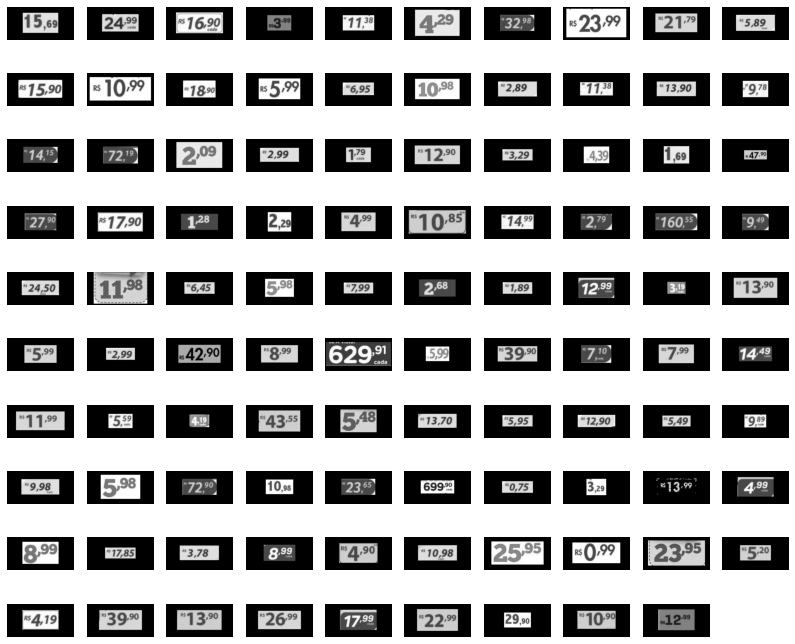

In [ ]:
precos = []
directory = 'precos'
onlyfiles = [f for f in listdir(directory) if isfile(join(directory, f))]
for image_path in onlyfiles: 
  precos.append((io.imread('precos/'+image_path,as_gray=True)* 255).astype ('uint8'))

exibir_imagens(precos,14,12,10,10)

Para ter melhores resultados, precisamos remover o fundo preto das imagens:

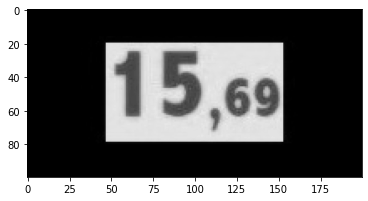

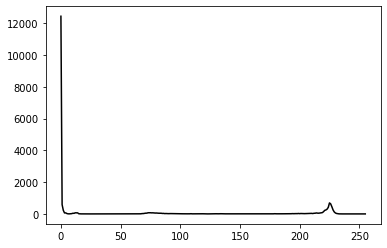

In [ ]:
preco = precos[0]

exibir_imagem(preco)
exibir_histograma(preco)

Como as imagens dos preços são retângulos, podemos verificar onde ocorre a troca entre preto e outra tom, e com isso saberemos onde cortar a imagem.

Minha primeira tentativa foi cortar a imagem exatamente no primeiro e ultimo pixel onde ocorre uma troca de cor, porém a maioria das imagens tem uma pequena variação de tom de preto, que fez com que o crop ficasse irregular e imperfeito.
Por isso, resolvi fazer o corte no primeiro e ultimo pixel que tem um valor maior que 10%, que seria 25.

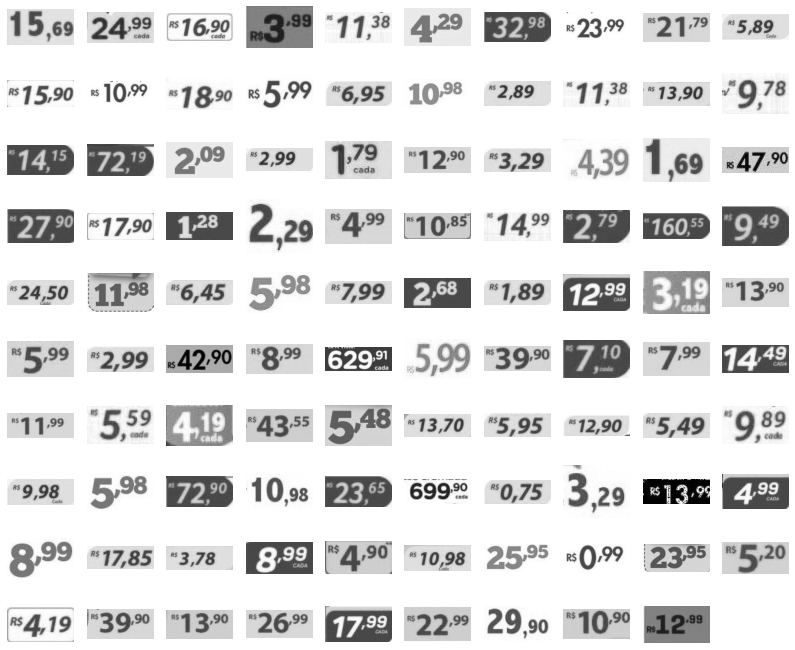

In [ ]:
def crop(imagem): 
  largura,comprimento = imagem.shape
  linha_horizontal = imagem[largura//2,:]
  linha_vertical = imagem[:,comprimento//2]

  nao_preto_horizontal = [i for i,v in enumerate(linha_horizontal) if v > 25]
  nao_preto_vertical = [i for i,v in enumerate(linha_vertical) if v > 25]

  return imagem[nao_preto_vertical[0]:nao_preto_vertical[-1],nao_preto_horizontal[0]:nao_preto_horizontal[-1]]

exibir_imagens(aplicar_filtros(precos,crop),14,12,10,10)

Testando o pytesseract:

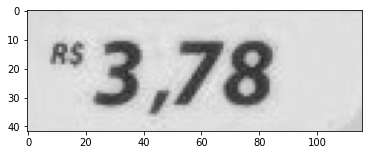

“3,78



In [ ]:
import pytesseract

imagem = crop(precos[82])

exibir_imagem(imagem)
print(pytesseract.image_to_string(crop(imagem)))

Para tentar deixar as imagems mais fáceis para o pytesseract, vou tentar reduzir qualquer pixel abaixo de 128 para 0, e qualquer pixel acima para 255


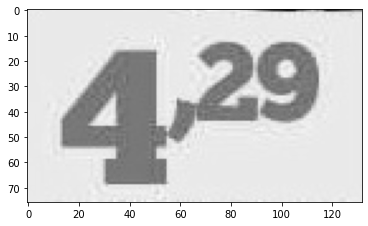

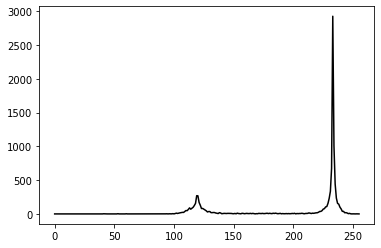

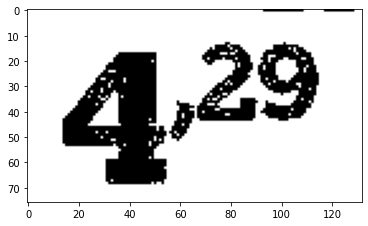

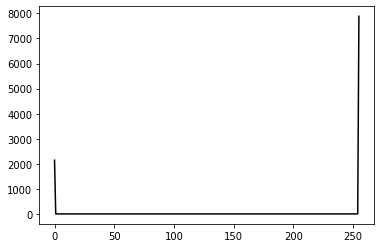

4.29



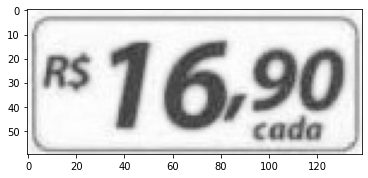

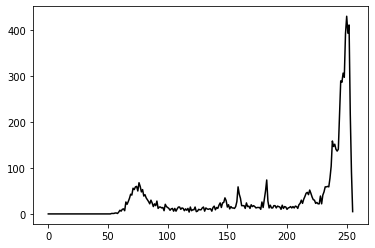

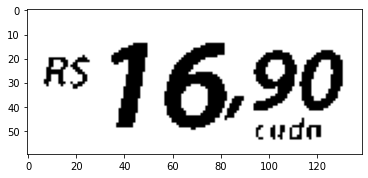

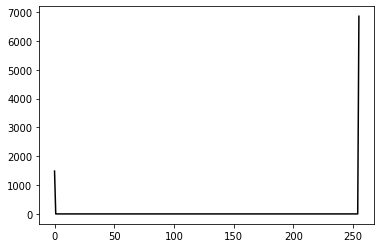

RS ] 6,90



In [ ]:
teste1 = crop(precos[5])
teste2 = crop(precos[2])

def modular(imagem):
  imagem_ = imagem.astype('int')

  imagem_[imagem_<128] = 0
  imagem_[imagem_>=128] = 255
  imagem_ = imagem_.astype ('uint8')
  return imagem_


analisar_imagem(teste1)
analisar_imagem(modular(teste1))

analisar_imagem(teste2)
analisar_imagem(modular(teste2))

Podemos ver que conseguimos fazer o pytesseract reconhecer o texto quase perfeitamente, salvo por detalhes em ambas imagens. Porém, em imagens onde ambos são mais escuros, ou pior, estão próximos do valor 128 como na 76: 
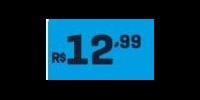
temos um resultado um tanto estranho: 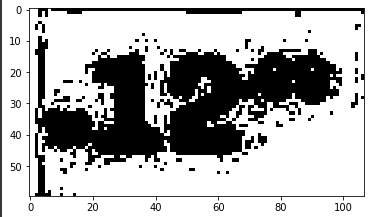

Portanto, vamos experimentar um realce nessa imagem, para tentar conseguir melhores resultados:

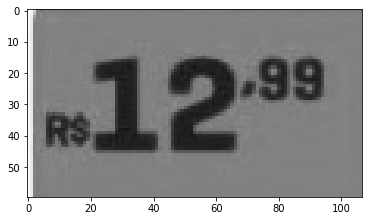

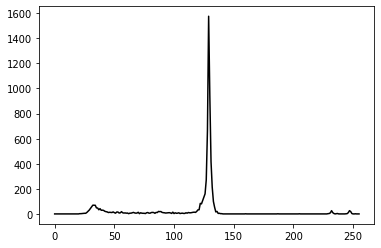

mtb oe



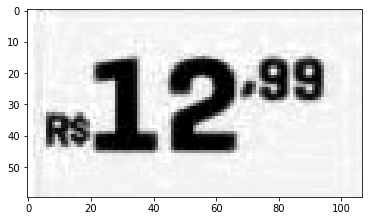

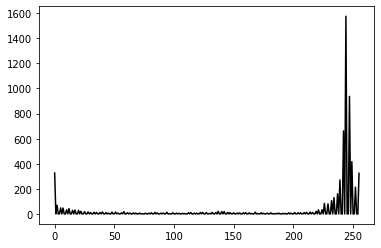

re debe



In [ ]:
teste = crop(precos[98])


def realcar(imagem):
  imagem_ = imagem.astype('int')*2
  amin = np.percentile (imagem_,5)
  amax = np.percentile (imagem_,95)
  imagem_[imagem_<amin] = amin
  imagem_[imagem_>amax] = amax

  imagem_ = imagem_ - imagem_.min()
  imagem_ = (imagem_ * 255) / imagem_.max()
  imagem_ = imagem_.astype ('uint8')
  return imagem_


analisar_imagem(teste)

analisar_imagem(realcar(teste))

Multiplicar ou dividir tiveram efeitos parecidos e não muito efetivos, portanto vamos testar a exponenciação:

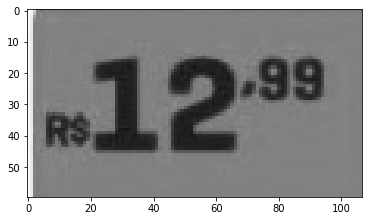

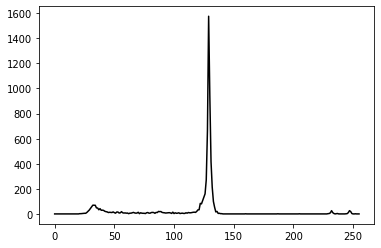

mtb oe



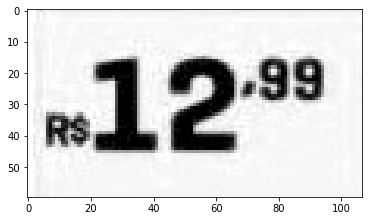

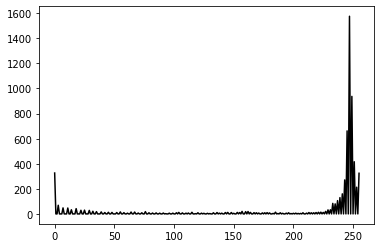

12”



In [ ]:
teste = crop(precos[98])


def exponenciar(imagem):
  imagem_ = imagem.astype('int')**0.5
  amin = np.percentile (imagem_,5)
  amax = np.percentile (imagem_,95)
  imagem_[imagem_<amin] = amin
  imagem_[imagem_>amax] = amax

  imagem_ = imagem_ - imagem_.min()
  imagem_ = (imagem_ * 255) / imagem_.max()
  imagem_ = imagem_.astype ('uint8')
  return imagem_


analisar_imagem(teste)
analisar_imagem(exponenciar(teste))

Aplicar a raiz de dois nos pixels teve o resultado com maior sucesso nessa imagem.

A seguir, vamos analisar como o brilho da imagem influencia no reconhecimento

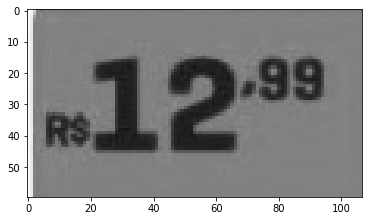

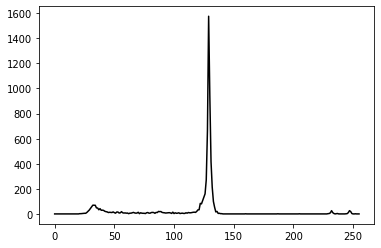

mtb oe



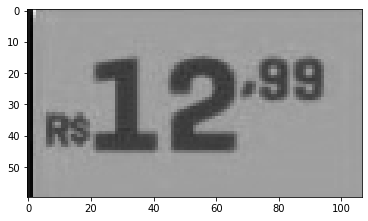

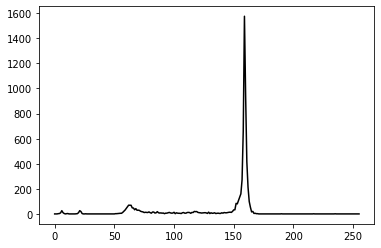

wL2*



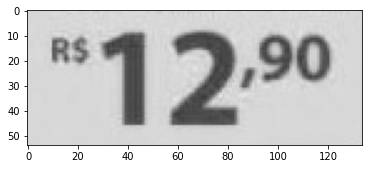

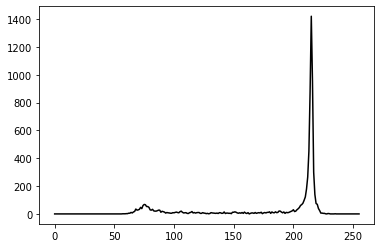

"4290



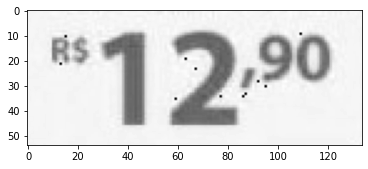

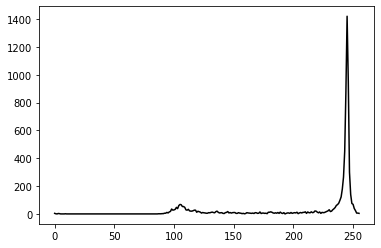

“42.90



In [ ]:
teste1 = crop(precos[56])
teste2 = crop(precos[25])

def brilho(imagem):
  imagem_ = imagem + 30
  imagem_[imagem_<0] = 0
  imagem_[imagem_>255] = 255
  imagem_ = imagem_.astype ('uint8')
  return imagem_


analisar_imagem(teste)
analisar_imagem(brilho(teste))

analisar_imagem(teste2)
analisar_imagem(brilho(teste2))

Testei com várias imagens, mas a 70 foi imagem que achei onde apenas o brilho ajudava no reconhecimento, onde a virgula passou a ser reconhecida como um ponto.

Até agora, desenvolvemos as seguintes funções:

-modular

-realcar

-exponenciar

-brilho

O objetivo da atividade era usar essas funções nas 100 imagen e atingir uma acurácia de 90%+ usando o pytesseract. Porém, ja pude perceber que isso não é um alvo muito realista, portanto vamos analisar o quão próximo o resultado do pytesseract é da imagem original, ao inves de decidir apenas entre certo e errado, e também analisar como os filtros influenciam no reconhecimento.

[img0018.png]: 
[img0093.png]: 
[img0100.png]: 
[img0027.png]: 
[img0059.png]: 
[img0090.png]: 
[img0046.png]: 
[img0073.png]: 
[img0068.png]: 
[img0002.png]: 
[img0021.png]: 
[img0078.png]: 
[img0099.png]: 
[img0023.png]: RS 599
[img0001.png]: "6,95
[img0092.png]: 
[img0041.png]: “2,89
[img0005.png]: 
[img0038.png]: 
[img0060.png]: 
[img0053.png]: 
[img0047.png]: 
[img0091.png]: 
[img0042.png]: 
[img0011.png]: 
[img0070.png]: 
[img0032.png]: "3,29
[img0003.png]: 
[img0017.png]: 
[img0024.png]: 
[img0006.png]: 
[img0095.png]: 
[img0089.png]: 
[img0016.png]: 
[img0061.png]: "499
[img0084.png]:  
[img0058.png]: 
[img0056.png]: 
[img0050.png]: 
[img0052.png]: 
[img0040.png]: 
[img0049.png]:  
[img0036.png]: “6,45
[img0012.png]: 
[img0031.png]: "7,99
[img0088.png]: 
[img0029.png]: “1,89
[img0096.png]: nel1232
[img0080.png]: 
[img0064.png]: 
[img0066.png]: 
[img0028.png]: “2,99
[img0025.png]: 
[img0065.png]: + 83°
[img0010.png]: 629":
[

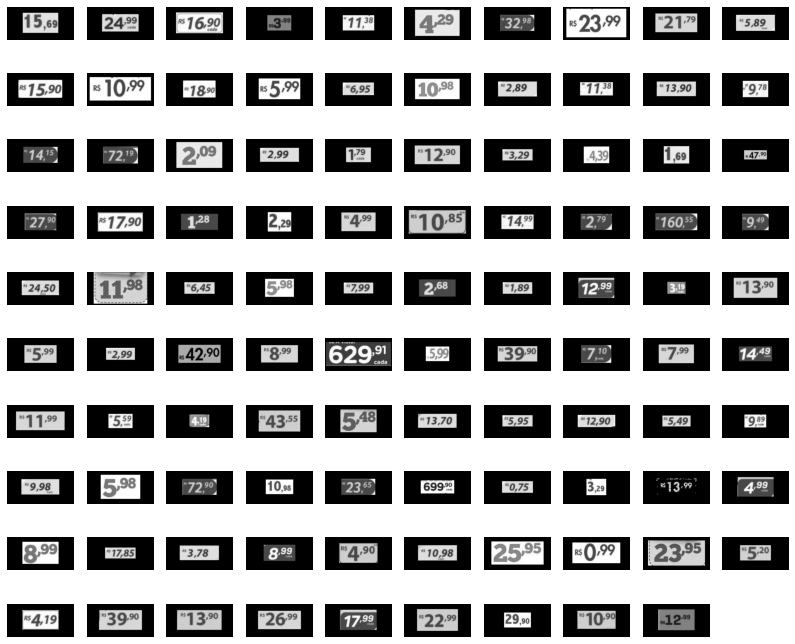

In [ ]:
aplicar_pytesseract(precos)
exibir_imagens(precos,14,12,10,10)

Em 24 das 100 imagens, algum caracter foi reconhecido.

Em 5 delas, o output foi algo não relacionado com a imagem.

19% de reconhecimento.

Vamos aplicar o crop e ver sua influência no reconhecimento do pytesseract:

[img0018.png]: 15.69
[img0093.png]: 2499
[img0100.png]: 
[img0027.png]: 
[img0059.png]: 
[img0090.png]: 
[img0046.png]: 
[img0073.png]: a 3 99
[img0068.png]: RS
[img0002.png]: “5,89
[img0021.png]: 
[img0078.png]: RS 10:99
[img0099.png]: =71 890
[img0023.png]: RS 599
[img0001.png]: "6,95
[img0092.png]: 
[img0041.png]: "2,89
[img0005.png]: 
[img0038.png]: “13,90
[img0060.png]: 
[img0053.png]: " thPa
[img0047.png]: "721%
[img0091.png]: 
[img0042.png]: "2,99
[img0011.png]: 172
[img0070.png]: "4290
[img0032.png]: 
[img0003.png]: 
[img0017.png]: 169
[img0024.png]: 
[img0006.png]: 
[img0095.png]: "317,90
[img0089.png]: 
[img0016.png]: 2.29
[img0061.png]: 
[img0084.png]: 
[img0058.png]: ie
[img0056.png]:  
[img0050.png]: 
[img0052.png]: 
[img0040.png]: “24,50
[img0049.png]: 
[img0036.png]: 
[img0012.png]: 
[img0031.png]: 
[img0088.png]: 
[img0029.png]: 
[img0096.png]: SyPe
[img0080.png]: Kay
[img0064.png]: "13%
[img0066.png]: = 59
[img0028.png

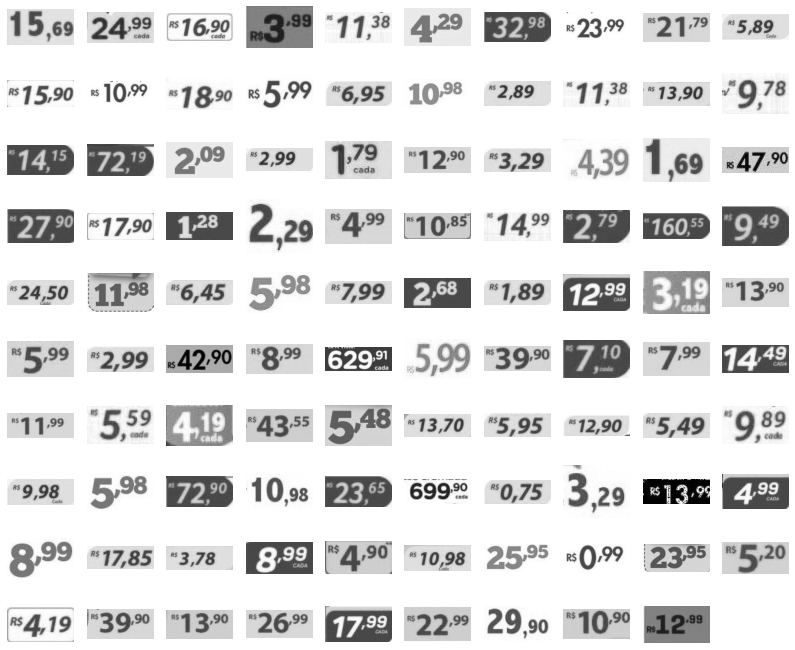

In [ ]:
precos_ = aplicar_filtros(precos, crop)
aplicar_pytesseract(precos_)
exibir_imagens(precos_,14,12,10,10)

Podemos ver que, apesar do crop fazer com que imagens que antes eram reconhecidas parem de ser, ele também faz com que um numéro maior tenha pelo menos algum caracter reconhecido. 

Em 48 das 100 imagens, algum caracter foi reconhecido.

Em 7 delas, o output foi algo não relacionado com a imagem.

41% de reconhecimento

Agora, vamos ver o efeito do filtro modular:

[img0018.png]: 15.69
[img0093.png]: 2499
[img0100.png]: RS ] 6,90
[img0027.png]: 
[img0059.png]: “47,38
[img0090.png]: 4.29
[img0046.png]:  5 2.Poa
[img0073.png]: 03.99
[img0068.png]: “217
[img0002.png]: "5,89
[img0021.png]: RS 7 5,90
[img0078.png]: 10-99
[img0099.png]: "1890
[img0023.png]: RS 599
[img0001.png]: “6,95
[img0092.png]: 
[img0041.png]: “2,89
[img0005.png]: “417,38
[img0038.png]: “13,90
[img0060.png]: 
[img0053.png]: Fae
[img0047.png]:  weaD
[img0091.png]: 2,09
[img0042.png]: “2,99
[img0011.png]:  
[img0070.png]: "4290
[img0032.png]: 
[img0003.png]: 
[img0017.png]: 1693
[img0024.png]: 
[img0006.png]: 
[img0095.png]: RS 1 7,90
[img0089.png]: 4128
[img0016.png]: 2.29
[img0061.png]: as 4”
[img0084.png]: 
[img0058.png]: “14,99
[img0056.png]:  
[img0050.png]: 
[img0052.png]: 
[img0040.png]: "24,50
[img0049.png]: 
[img0036.png]: 
[img0012.png]: 
[img0031.png]: 
[img0088.png]: 
[img0029.png]: 
[img0096.png]: Pad
[img0080.png]: 
[img

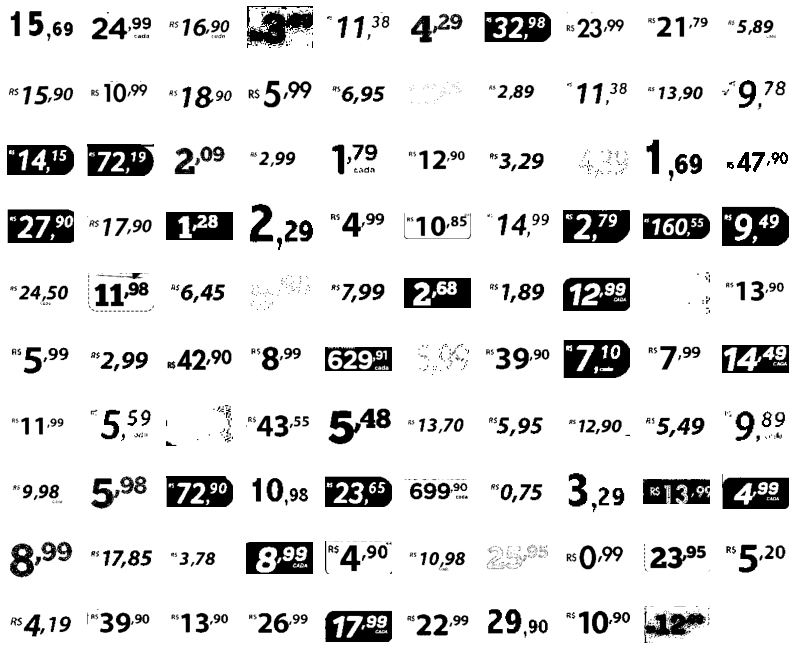

In [ ]:
precos_ = aplicar_filtros(precos, crop,modular)
aplicar_pytesseract(precos_)
exibir_imagens(precos_,14,12,10,10)

Em 61 das 100 imagens, algum caracter foi reconhecido.

Em 6 delas, o output foi algo não relacionado com a imagem.

56% de reconhecimento.


Agora, vamos usar os filtros de realce/exponenciação/brilho.

[img0018.png]: 1569
[img0093.png]: 2499
[img0100.png]: 16,90)
[img0027.png]: 
[img0059.png]: "1 1,38
[img0090.png]: 
[img0046.png]: 
[img0073.png]: ei 3 99
[img0068.png]: RS
[img0002.png]: “5,89
[img0021.png]: 
[img0078.png]: RS 10:99
[img0099.png]: =7 890
[img0023.png]: RS 599
[img0001.png]: "6,95
[img0092.png]: 
[img0041.png]: "2,89
[img0005.png]: 
[img0038.png]: “13,90
[img0060.png]: 
[img0053.png]: i Pa
[img0047.png]:  wWPaD
[img0091.png]: 
[img0042.png]: "2,99
[img0011.png]: 172
[img0070.png]: "4290
[img0032.png]: 
[img0003.png]: 
[img0017.png]: 169
[img0024.png]: 
[img0006.png]: 
[img0095.png]: "317,90
[img0089.png]: 
[img0016.png]: 2.29
[img0061.png]: 
[img0084.png]: 
[img0058.png]: “14,
[img0056.png]:  
[img0050.png]: 
[img0052.png]: 
[img0040.png]: "24,50
[img0049.png]: 
[img0036.png]: 
[img0012.png]: 
[img0031.png]: 
[img0088.png]: 
[img0029.png]: 
[img0096.png]: aSPa
[img0080.png]: Kay
[img0064.png]: "13°
[img0066.png]: = 59

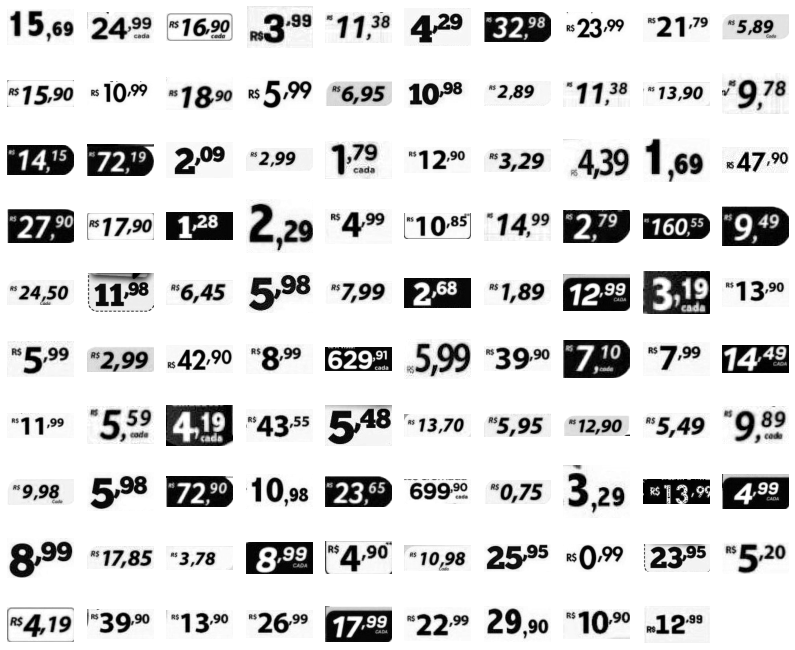

In [ ]:
precos_ = aplicar_filtros(precos, crop,realcar)
aplicar_pytesseract(precos_)
exibir_imagens(precos_,14,12,10,10)

Em 49 das 100 imagens, algum caracter foi reconhecido.

Em 8 delas, o output foi algo não relacionado com a imagem.

41% de reconhecimento.

[img0018.png]: 15,69
[img0093.png]: 2499
[img0100.png]: es 16,90 
[img0027.png]: 
[img0059.png]: 
[img0090.png]: 
[img0046.png]:  oy >yoo)
[img0073.png]: ms 23 99
[img0068.png]: RS
[img0002.png]: “5,89
[img0021.png]: "$71 5,90
[img0078.png]: 10/99
[img0099.png]: "1890
[img0023.png]: RS 599
[img0001.png]: *6,95
[img0092.png]: 10-°°
[img0041.png]: “2,89
[img0005.png]: 
[img0038.png]: “13,90
[img0060.png]: 
[img0053.png]: Pa
[img0047.png]:  i »ipa
[img0091.png]: 2°9
[img0042.png]: "2,99
[img0011.png]: 
[img0070.png]: "4290
[img0032.png]: 
[img0003.png]: 
[img0017.png]: 169
[img0024.png]: 
[img0006.png]: 
[img0095.png]: ms 17,90
[img0089.png]: 
[img0016.png]: 2.29
[img0061.png]: 
[img0084.png]: 
[img0058.png]: “14,9
[img0056.png]:  
[img0050.png]: 
[img0052.png]: 
[img0040.png]: “24,50
[img0049.png]: 
[img0036.png]: 
[img0012.png]: 
[img0031.png]: 
[img0088.png]: 
[img0029.png]: 
[img0096.png]: iPad
[img0080.png]: ea
[img0064.png]: "13°
[im

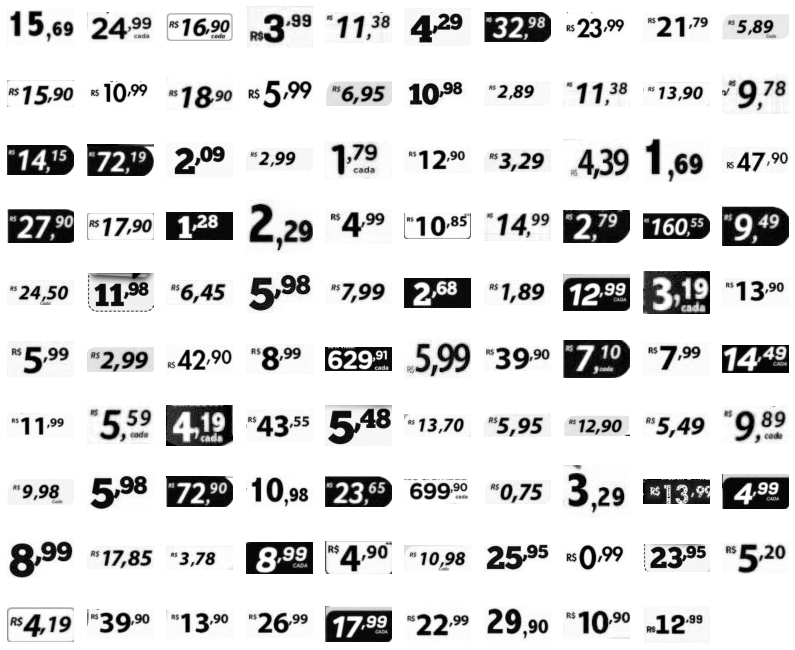

In [ ]:
precos_ = aplicar_filtros(precos, crop,exponenciar)
aplicar_pytesseract(precos_)
exibir_imagens(precos_,14,12,10,10)

Em 56 das 100 imagens, algum caracter foi reconhecido.

Em 6 delas, o output foi algo não relacionado com a imagem.

50% de reconhecimento.

[img0018.png]:  
[img0093.png]:  
[img0100.png]: eos
[img0027.png]: 
[img0059.png]: 
[img0090.png]: 
[img0046.png]:  o 2>32%
[img0073.png]: OY Yo)
[img0068.png]: RS
[img0002.png]:  
[img0021.png]: 
[img0078.png]: es (Ore
[img0099.png]: dt
[img0023.png]: Fe aks
[img0001.png]:  
[img0092.png]: 
[img0041.png]:  
[img0005.png]: 
[img0038.png]:  
[img0060.png]: BR
[img0053.png]: ” “aPa
[img0047.png]:  72,19)
[img0091.png]: 
[img0042.png]:  
[img0011.png]:  
[img0070.png]: “42.90
[img0032.png]:  
[img0003.png]: 
[img0017.png]: NGO
[img0024.png]: 
[img0006.png]: 
[img0095.png]: ea PALS
[img0089.png]: 
[img0016.png]: 
[img0061.png]: 
[img0084.png]: 
[img0058.png]: 
[img0056.png]:  
[img0050.png]: 
[img0052.png]: 
[img0040.png]:  
[img0049.png]: 
[img0036.png]:  
[img0012.png]: 
[img0031.png]:  
[img0088.png]: 
[img0029.png]: 
[img0096.png]: 
[img0080.png]: 
[img0064.png]: “13”
[img0066.png]: "5,99
[img0028.png]:  
[img0025.png]: 
[img0065.pn

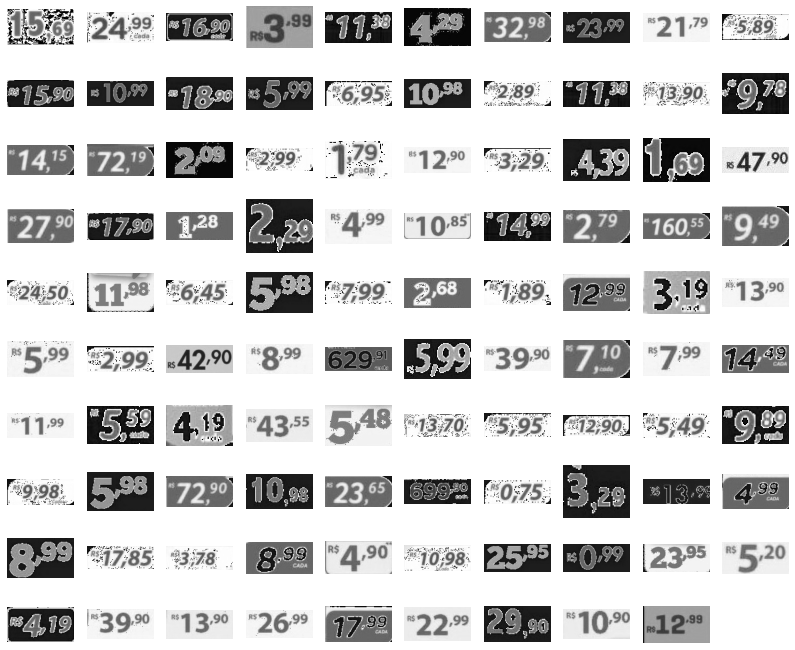

In [ ]:
precos_ = aplicar_filtros(precos, crop,brilho)
aplicar_pytesseract(precos_)
exibir_imagens(precos_,14,12,10,10)